In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch

import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

In [2]:
from diffSPH.v2.finiteDifference import computeGradient
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

def plotSDF(fx, X, Y, extent, dim, ngrid = 255):
    fig, axis = plt.subplots(1, 3, figsize=(14,4), sharex = False, sharey = False, squeeze = False)

    fx = fx.reshape(ngrid, ngrid)
    output = computeGradient(fx, extent, dim, 1)
    # Plot the isocontours of fx
    axis[0,0].contour(X.numpy(), Y.numpy(), fx.numpy(), levels=[0], colors='black')


    # sdfValues = sdCircle(P, 1.0)
    # sdfGradient = gradient(sdfValues, 4, 1, 2)
    # sdfGradient = torch.stack([centralDifference(sdfValues, 1/ngrid, 1, 4), centralDifference(sdfValues, 1/ngrid, 1, 4)], axis=-1)
    # sdfValues = fx
    # sdfGradient = output
    # print(sdfGradient.shape)

    im = axis[0,0].pcolormesh(X.numpy(), Y.numpy(), fx.numpy(), cmap='Spectral',vmin = - torch.max(torch.abs(fx)).numpy(), vmax = torch.max(torch.abs(fx)).numpy())
    axis[0,0].set_title("SDF")
    axis[0,0].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    spacing = 16
    axis[0,0].quiver(X[::spacing,::spacing].numpy(), Y[::spacing,::spacing].numpy(), output[::spacing,::spacing,0].numpy(), output[::spacing,::spacing,1].numpy())

    im = axis[0,1].pcolormesh(X.numpy(), Y.numpy(), output[:,:,0].numpy(), cmap='viridis')
    axis[0,1].set_title("SDF Gradient X")
    axis[0,1].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axis[0,2].pcolormesh(X.numpy(), Y.numpy(), output[:,:,1].numpy(), cmap='viridis')
    axis[0,2].set_title("SDF Gradient Y")
    axis[0,2].set_aspect('equal', 'box')
    divider = make_axes_locatable(axis[0,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    # im = axis[0,3].imshow(torch.linalg.norm(output[:,:], dim = -1), extent=(-2, 2, -2, 2), origin='lower', cmap='inferno')
    # axis[0,3].set_title("SDF Gradient Magnitude")
    # divider = make_axes_locatable(axis[0,3])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im, cax=cax, orientation='vertical')
    # axis[0,3].set_title("SDF Gradient")
    # axis[0,3].set_aspect('equal', 'box')
    # axis[0,3].set_xlim(-2, 2)
    # axis[0,3].set_ylim(-2, 2)

    fig.tight_layout()


In [3]:
ngrid = 255
x = torch.linspace(-2, 2, ngrid, dtype = torch.float32)
y = torch.linspace(-2, 2, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

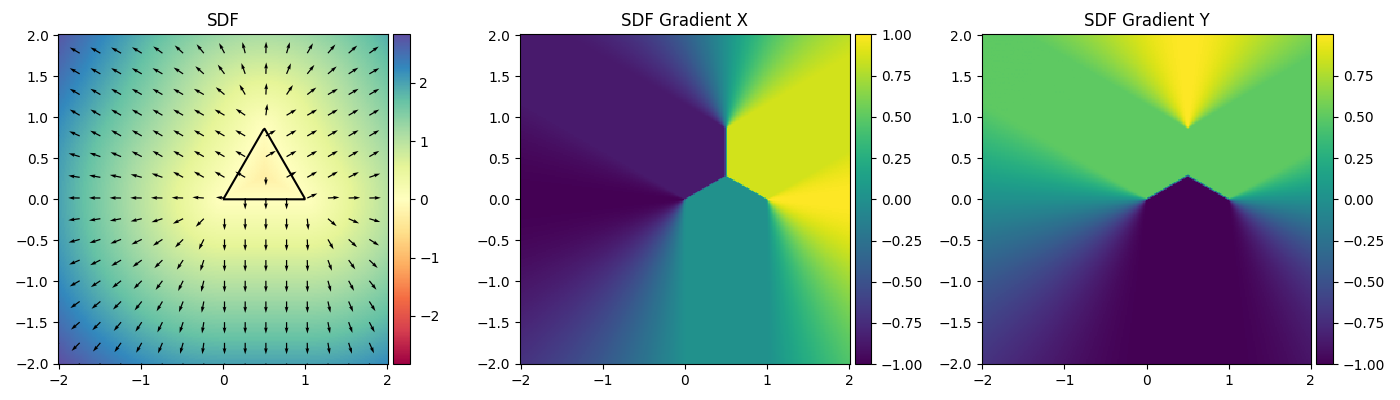

In [4]:
sdfFunctions = ['polygon']

for name in sdfFunctions:
    sdf = getSDF(name)
    plotSDF(sdf['function'](torch.clone(points), *sdf['sample']), X, Y, 4, 2, ngrid)

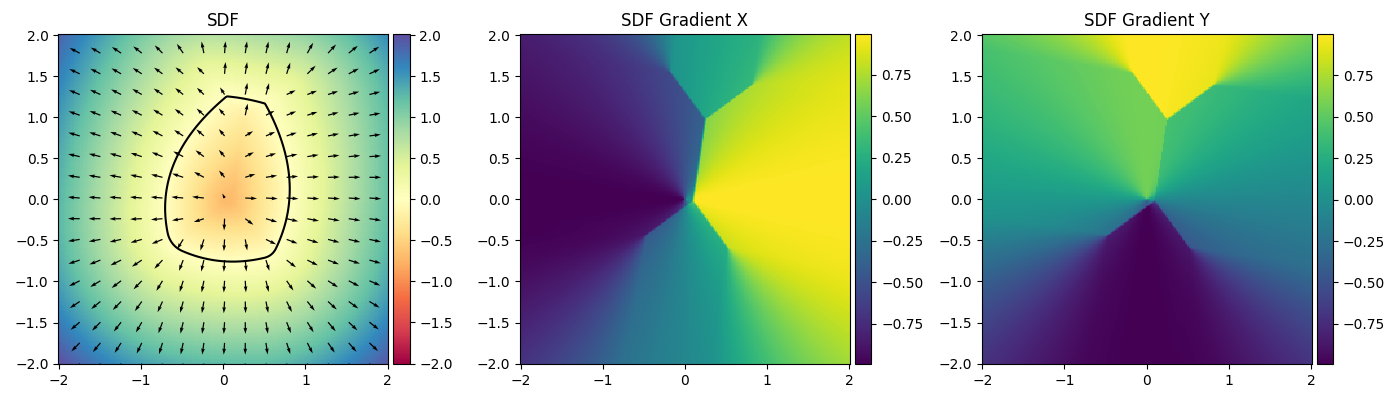

In [5]:
sphere_a = lambda points: getSDF('circle')['function'](points, 1.0)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.5,1.0]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.5]))
rotated = operatorDict['rotate'](translated, 0.15)
sdf = operatorDict['blend'](rotated, sphere_a, 0.5)
plotSDF(sdf(torch.clone(points),), X, Y, 4, 2)